# Classificação de Imagens de Radiografia de Tórax (Pneumonia)

<a href="https://colab.research.google.com/github/fabiobento/edge-ml/blob/main/computer-vision/classification/chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A utilização de técnicas de aprendizado profundo para diagnóstico médico a partir de imagens é uma área de grande impacto e interesse na pesquisa biomédica, especialmente no contexto de doenças tratáveis como a pneumonia. O trabalho [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) de Rajpurkar et al. (2018), publicado na revista Cell, demonstra o potencial dos modelos baseados em aprendizado profundo para realizar diagnósticos precisos a partir de imagens médicas, evidenciando que redes neurais convolucionais (CNNs) podem alcançar acurácias comparáveis às de radiologistas experientes. Inspirado por esses avanços, o presente estudo emprega o conjunto de dados ["Chest X-Ray Images (Pneumonia)"](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) disponibilizado por Mooney no Kaggle (MOONEY, 2018),, composto por radiografias de tórax, com o objetivo de treinar um modelo de rede neural capaz de classificar casos de pneumonia e normalidade em imagens de raios-X.

Neste estudo, utilizamos o [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), uma API de alto nível do TensorFlow (ABADI et al., 2015), para construir e treinar um modelo de CNN para a classificação de imagens de raios-X, ilustrando desde o carregamento eficiente de dados, com [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory), até o treinamento e ajuste do modelo. Com isso, abordamos conceitos essenciais de aprendizado profundo aplicados ao diagnóstico por imagem, incluindo o gerenciamento de sobreajuste, onde implementamos técnicas de aumento de dados (data augmentation) e eliminação de imagens redundantes para melhorar a capacidade de generalização do modelo.

Seguindo um fluxo de trabalho padrão de aprendizado de máquina, este estudo será conduzido nas seguintes etapas:
1. exame e compreensão dos dados do conjunto,
2. criação de um _pipeline_ de entrada para processamento e carregamento,
3. construção do modelo de CNN,
4. treinamento supervisionado,
5. avaliação e teste de desempenho e, finalmente,
6. aprimoramento contínuo do modelo. Este fluxo reflete a importância de iterações e ajustes contínuos no treinamento de modelos de aprendizado profundo para garantir diagnósticos mais precisos e confiáveis.

### Referências

RAJPURKAR, P. et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell, v. 172, n. 5, p. 1122-1131, 2018. Disponível em: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5. Acesso em: 28 out. 2024.

MOONEY, P. Chest X-Ray Images (Pneumonia) [online]. Kaggle, 2018. Disponível em: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia. Acesso em: 28 out. 2024.

ABADI, M. et al. TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems. 2015. Disponível em: https://www.tensorflow.org/. Acesso em: 28 out. 2024.

Este tutorial mostra como classificar imagens de flores usando um modelo `tf.keras.Sequential` e carregar dados usando `tf.keras.utils.image_dataset_from_directory`. Ele demonstra os seguintes conceitos:


* Carregamento eficiente de um conjunto de dados do disco.
* Identificação de sobreajuste e aplicação de técnicas para atenuá-lo, incluindo aumento e eliminação de dados.

Este tutorial segue um fluxo de trabalho básico de aprendizado de máquina:

1. Examinar e entender os dados
2. Criar um pipeline de entrada
3. Criar o modelo
4. Treinar o modelo
5. Testar o modelo
6. Aprimore o modelo e repita o processo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-10-28 22:34:09.455406: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 22:34:09.463968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 22:34:09.475018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 22:34:09.478327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 22:34:09.486888: I tensorflow/core/platform/cpu_feature_guar

## Preprocessamento dos dados

### Download dos dados

Neste tutorial, você usará um conjunto de dados que contém vários milhares de imagens de cães e gatos.

Faça download e extraia um arquivo zip contendo as imagens e, em seguida, crie um `tf.data.Dataset` para treinamento e validação usando o utilitário `tf.keras.utils.image_dataset_from_directory`.

Você pode saber mais sobre o carregamento de imagens neste [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [2]:
try:
    import google.colab
    IN_COLAB = True
    print("Executando no Google Colab")
except ImportError:
    IN_COLAB = False
    print("Não executando no Google Colab")

Não executando no Google Colab


In [3]:
if IN_COLAB:
  # Baixar arquivo do conjunto de dados 
  %pip install gdown
  !mkdir -p ./datasets
  !gdown --id 1KkcIObRhAlaB0zr6Soxpowb4gD7wgYuH -O ./datasets/chest_xray.zip
  !unzip -n -q ./datasets/chest_xray.zip
  train_dir = "/content/chest_xray/train"
  test_dir = "/content/chest_xray/test"
else:
  train_dir = "/workspace/computer-vision/classification/datasets/chest_xray/train"
  test_dir = "/workspace/computer-vision/classification/datasets/chest_xray/test"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)


In [4]:
# Definir a porcentagem para validação
validation_split = 0.2  # 20% para validação
train_dataset = tf.keras.utils.image_dataset_from_directory(
                                        train_dir,
                                        validation_split=validation_split,  # divisão para validação
                                        subset="training",  # define o conjunto como de treino
                                        seed=42,  # semente para garantir a mesma divisão                                                            
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.


I0000 00:00:1730154850.555154   19374 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730154850.561910   19374 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730154850.565349   19374 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730154850.569063   19374 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
                                        train_dir, # mesmo diretório
                                        validation_split=validation_split,  # mesma divisão para validação
                                        subset="validation",  # define o conjunto como de validação
                                        seed=42,  # semente para garantir a mesma divisão                                                                    
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


In [6]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
                                        test_dir,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

Found 624 files belonging to 2 classes.


Mostre as primeiras nove imagens e rótulos do conjunto de treinamento:

2024-10-28 22:34:11.694640: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


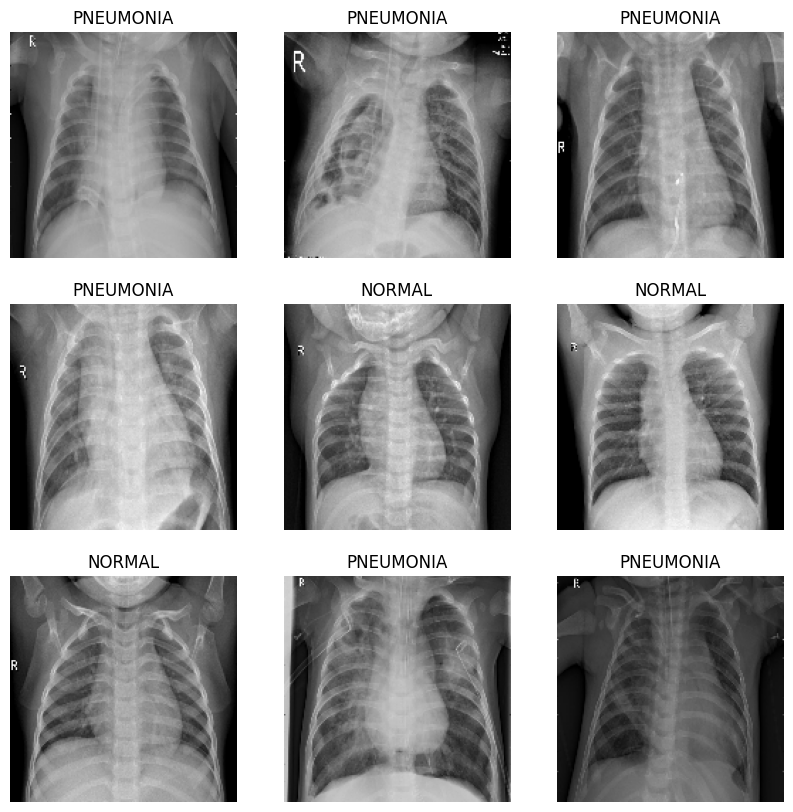

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Como o conjunto de dados original não contém um conjunto de teste, você criará um.

Para fazer isso, determine quantos lotes de dados estão disponíveis no conjunto de validação usando `tf.data.experimental.cardinality` e, em seguida, mova 20% deles para um conjunto de teste.

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Número de lotes de validação: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Número de lotes de teste: %d' % tf.data.experimental.cardinality(test_dataset))

Número de lotes de validação: 27
Número de lotes de teste: 6


### Configurar o conjunto de dados para desempenho

Use a pré-busca com buffer(_buffered prefetching_) para carregar imagens do disco sem que a E/S se torne bloqueada. Para saber mais sobre esse método, consulte o guia [data performance](https://www.tensorflow.org/guide/data_performance).

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use _data augmentation_

Quando não se tem um grande conjunto de dados de imagens, é uma boa prática introduzir artificialmente a diversidade de amostras aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como rotação e inversão horizontal.

Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento e a reduzir o [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Você pode saber mais sobre o aumento de dados neste [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Observação: essas camadas ficam ativas somente durante o treinamento, quando você chama `Model.fit`. Elas ficam inativas quando o modelo é usado no modo de inferência em `Model.evaluate`, `Model.predict` ou `Model.call`.

Vamos aplicar repetidamente essas camadas à mesma imagem e ver o resultado.

2024-10-28 22:34:12.620487: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


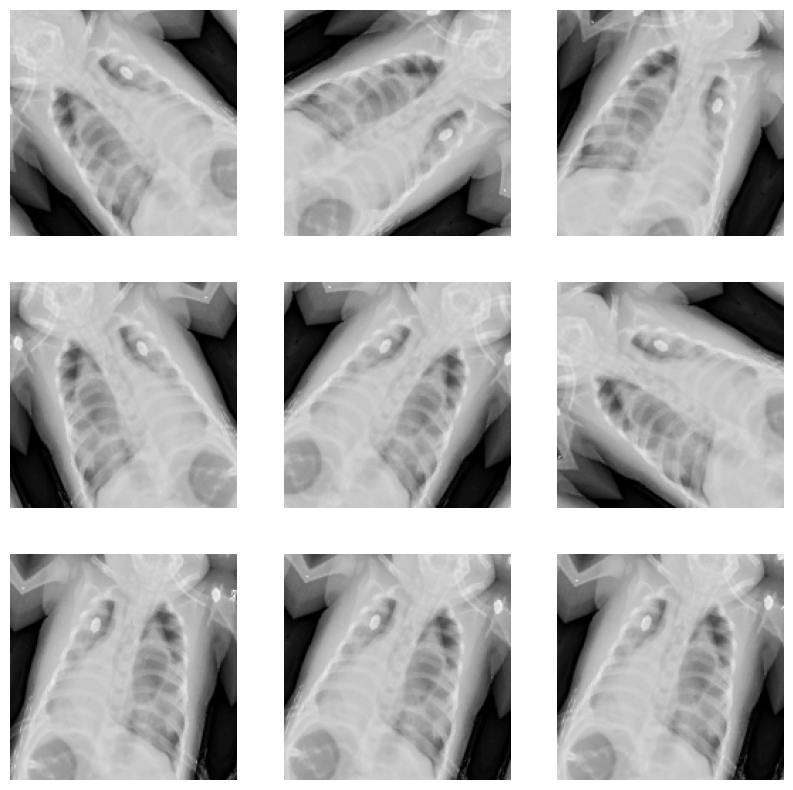

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Redimensionar valores de pixel

Em breve, você fará o download do `tf.keras.applications.MobileNetV2` para usá-lo como seu modelo básico.

Esse modelo espera valores de pixel em `[-1, 1]`, mas, nesse momento, os valores de pixel em suas imagens estão em `[0, 255]`. Para redimensioná-los, use o método de pré-processamento incluído no modelo.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Observação: como alternativa, você pode redimensionar os valores de pixel de `[0, 255]` para `[-1, 1]` usando `tf.keras.layers.Rescaling`.

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Observação: se estiver usando outros `tf.keras.applications`, verifique o documento da API para determinar se eles esperam pixels em `[-1, 1]` ou `[0, 1]`, ou use a função `preprocess_input` incluída.

## Crie o modelo básico a partir de convnets pré-treinadas
Você criará o modelo básico a partir do modelo **MobileNet V2** desenvolvido no Google.
- Ele é pré-treinado no conjunto de dados ImageNet, um grande conjunto de dados que consiste em 1,4 milhão de imagens e 1.000 classes.
- O ImageNet é um conjunto de dados de treinamento de pesquisa com uma ampla variedade de categorias, como `jackfruit` e `syringe`.
- Essa base de conhecimento nos ajudará a classificar gatos e cachorros em nosso conjunto de dados específico.

Primeiro, você precisa escolher a camada do MobileNet V2 que usará para extração de recursos.
- A última camada de classificação (no “topo”, já que a maioria dos diagramas de modelos de aprendizado de máquina vai de baixo para cima) não é muito útil.
- Em vez disso, você seguirá a prática comum de depender da última camada antes da operação de _flattening_.
- Essa camada é chamada de “camada de gargalo”.
- Os recursos da camada de gargalo mantêm mais generalidade em comparação com a camada final/superior.

Primeiro, instancie um modelo MobileNet V2 pré-carregado com pesos treinados no ImageNet.
- Ao especificar o argumento **include_top=False**, você carrega uma rede que não inclui as camadas de classificação na parte superior, o que é ideal para a extração de recursos.

In [15]:
# Criar o modelo básico a partir do modelo pré-treinado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Esse extrator de recursos converte cada imagem `160x160x3` em um bloco de recursos `5x5x1280`. Vejamos o que ele faz em um exemplo de lote de imagens:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-10-28 22:34:13.389092: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1730154853.432880   19374 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154853.443811   19374 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154853.445164   19374 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154853.449737   19374 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154853.451470   19374 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154853.453052   19374 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154853.454803   19374 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154853.456300   19374 gpu_t

(32, 5, 5, 1280)


## Extração de recursos
Nesta etapa, você congelará a base convolucional criada na etapa anterior e a usará como um extrator de recursos. Além disso, você adiciona um classificador sobre ele e treina o classificador de nível superior.

### Congelar a base convolucional

É importante congelar a base convolucional antes de compilar e treinar o modelo.

O congelamento (definindo layer.trainable = False) impede que os pesos em uma determinada camada sejam atualizados durante o treinamento.

O MobileNet V2 tem muitas camadas, portanto, definir o sinalizador `trainable` do modelo inteiro como False congelará todas elas.

In [17]:
base_model.trainable = False

### Observação importante sobre as camadas de BatchNormalization

Muitos modelos contêm camadas `tf.keras.layers.BatchNormalization`. Essa camada é um caso especial e devem ser tomadas precauções no contexto do fine tuning, conforme mostrado mais adiante neste tutorial.

Quando você define `layer.trainable = False`, a camada `BatchNormalization` será executada no modo de inferência e não atualizará suas estatísticas de média e variância.

Quando você descongela um modelo que contém camadas de BatchNormalization para fazer o fine tuning, deve manter as camadas de BatchNormalization no modo de inferência passando `training = False` ao chamar o modelo básico. Caso contrário, as atualizações aplicadas aos pesos não treináveis destruirão o que o modelo aprendeu.

Para obter mais detalhes, consulte o [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [18]:
# Vamos dar uma olhada na arquitetura do modelo básico
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Adicionar um cabeçalho de classificação

Para gerar previsões a partir do bloco de recursos, faça a média dos valores espaciais `5x5`, usando uma camada `tf.keras.layers.GlobalAveragePooling2D` para converter os recursos em um único vetor de 1280 elementos por imagem.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique uma camada `tf.keras.layers.Dense` para converter esses recursos em uma única previsão por imagem.

Você não precisa de uma função de ativação aqui porque essa previsão será tratada como um `logit` ou um valor de previsão bruto.

Números positivos predizem a classe 1, números negativos predizem a classe 0.

In [20]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Crie um modelo encadeando as camadas de aumento de dados, redimensionamento, `base_model` e extrator de recursos usando a [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

Conforme mencionado anteriormente, use `training=False`, pois nosso modelo contém uma camada `BatchNormalization`.

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Os mais de 8 milhões de parâmetros no MobileNet estão congelados, mas há 1,2 mil parâmetros _treináveis_ na camada Dense.

Eles são divididos entre dois objetos `tf.Variable`, os pesos e as tendências.

In [23]:
len(model.trainable_variables)

2

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Compilar o modelo

Compile o modelo antes de treiná-lo. Como há duas classes e uma saída sigmoide, use o `BinaryAccuracy`.

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Treinar o modelo

Após o treinamento de 10 épocas, você deverá ver ~96% de acurácia no conjunto de validação.


In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2578 - loss: 1.8187


W0000 00:00:1730154855.570205   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.571376   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.572426   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.574507   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.575739   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.577214   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.578754   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.580386   19468 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154855.582192   19468 gp

In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.84
initial accuracy: 0.25


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3901 - loss: 1.2076

W0000 00:00:1730154862.731939   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.733127   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.734207   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.735676   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.736815   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.737957   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.739095   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.740384   19467 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154862.741677   19467 gp

131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.3911 - loss: 1.2054 - val_accuracy: 0.7272 - val_loss: 0.5698
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6837 - loss: 0.6278 - val_accuracy: 0.8091 - val_loss: 0.4717
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7531 - loss: 0.5224 - val_accuracy: 0.8595 - val_loss: 0.4090
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7943 - loss: 0.4428 - val_accuracy: 0.8747 - val_loss: 0.3626
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8303 - loss: 0.3850 - val_accuracy: 0.8888 - val_loss: 0.3318
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8657 - loss: 0.3372 - val_accuracy: 0.8876 - val_loss: 0.3140
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8745 - loss: 0.3097 - val_accuracy: 0.8958 - val_loss: 0.2887
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.8951 - loss: 0.2813 - val_accuracy: 0.898

### Curvas de aprendizado

Vamos dar uma olhada nas curvas de aprendizado da acurácia/perda de treinamento e validação ao usar o modelo básico MobileNetV2 como um extrator de recursos fixo.

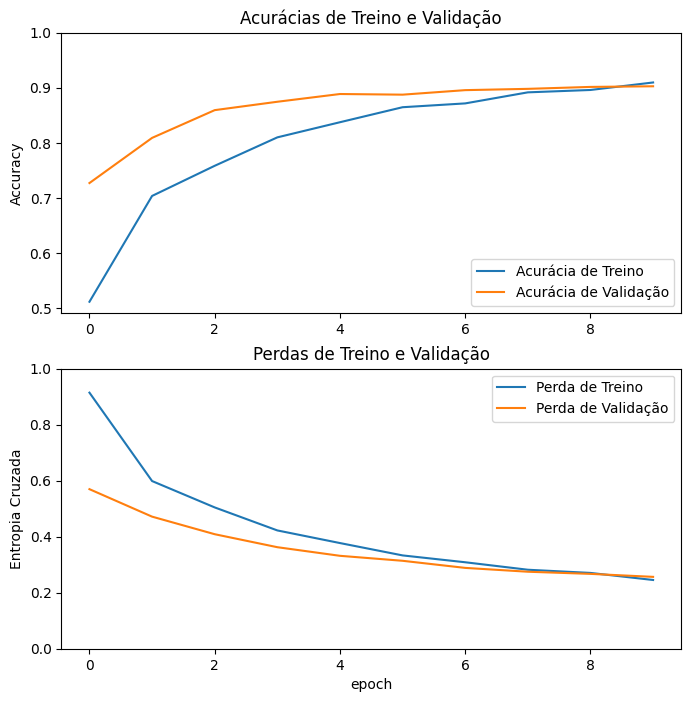

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acurácia de Treino')
plt.plot(val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Acurácias de Treino e Validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda de Treino')
plt.plot(val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,1.0])
plt.title('Perdas de Treino e Validação')
plt.xlabel('epoch')
plt.show()

Observação: Se você estiver se perguntando por que as métricas de validação são claramente melhores do que as métricas de treinamento, o principal fator é que camadas como `tf.keras.layers.BatchNormalization` e `tf.keras.layers.Dropout` afetam a acurácia durante o treinamento. Elas são desativadas ao calcular a perda de validação.

Em menor escala, isso também ocorre porque as métricas de treinamento relatam a média de uma época, enquanto as métricas de validação são avaliadas após a época, de modo que as métricas de validação veem um modelo que treinou um pouco mais.

## Fine tuning

No experimento de extração de recursos, você estava treinando apenas algumas camadas sobre um modelo básico do MobileNetV2.
* Os pesos da rede pré-treinada **não** foram atualizados durante o treinamento.

Uma maneira de aumentar ainda mais o desempenho é treinar (ou “ajustar”) os pesos das camadas superiores do modelo pré-treinado juntamente com o treinamento do classificador que você adicionou.
* O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para recursos associados especificamente ao conjunto de dados.


Observação: isso só deve ser tentado depois que você tiver treinado o classificador de nível superior com o modelo pré-treinado definido como não treinável.
* Se você adicionar um classificador inicializado aleatoriamente em cima de um modelo pré-treinado e tentar treinar todas as camadas em conjunto, a magnitude das atualizações de gradiente será muito grande (devido aos pesos aleatórios do classificador) e o modelo pré-treinado esquecerá o que aprendeu.

Além disso, você deve tentar fazer o Fine tuning de um pequeno número de camadas superiores em vez de todo o modelo MobileNet.
* Na maioria das redes convolucionais, quanto mais alta for uma camada, mais especializada ela será.
* As primeiras camadas aprendem recursos muito simples e genéricos que se aplicam a quase todos os tipos de imagens.
* À medida que você sobe de nível, os recursos são cada vez mais específicos para o conjunto de dados no qual o modelo foi treinado.
* O objetivo do Fine tuning é adaptar esses recursos especializados para que funcionem com o novo conjunto de dados, em vez de substituir o aprendizado genérico.

### Descongelar as camadas superiores do modelo


Tudo o que você precisa fazer é descongelar o `base_model` e definir as camadas inferiores como não treináveis.

Em seguida, você deve recompilar o modelo (necessário para que essas alterações tenham efeito) e retomar o treinamento.

In [30]:
base_model.trainable = True

In [31]:
# Vamos dar uma olhada para ver quantas camadas existem no modelo básico
print("Número de camadas no modelo básico: ", len(base_model.layers))

# Fine tuning a partir dessa camada
fine_tune_at = 100

# Congelar todas as camadas antes da camada `fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Número de camadas no modelo básico:  154


### Compilar o modelo

Como você está treinando um modelo muito maior e deseja readaptar os pesos pré-treinados, é importante usar uma taxa de aprendizado menor nesse estágio. Caso contrário, seu modelo poderá se ajustar muito rapidamente.

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [34]:
len(model.trainable_variables)

56

### Continuar o treinamento do modelo

Se você treinou para a convergência mais cedo, essa etapa aumentará sua acurácia em alguns pontos percentuais.

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20


W0000 00:00:1730154919.639216   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.654635   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.655802   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.657045   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.658282   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.659560   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.663717   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.664940   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154919.666411   19464 gp

  1/131 ━━━━━━━━━━━━━━━━━━━━ 14:24 7s/step - accuracy: 0.7812 - loss: 0.3847

W0000 00:00:1730154921.523064   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.524189   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.525281   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.526378   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.527871   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.529900   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.531162   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.532542   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154921.533634   19464 gp

130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8691 - loss: 0.3061

W0000 00:00:1730154929.119016   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.120209   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.121310   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.122461   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.123588   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.124701   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.125866   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.127115   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154929.129203   19464 gp

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8693 - loss: 0.3058

W0000 00:00:1730154930.732279   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.733345   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.734400   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.735476   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.736524   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.737603   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.738641   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.739713   19464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730154930.740801   19464 gp

131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.8695 - loss: 0.3055 - val_accuracy: 0.8899 - val_loss: 0.2560
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9289 - loss: 0.2036 - val_accuracy: 0.8958 - val_loss: 0.2478
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9398 - loss: 0.1600 - val_accuracy: 0.9215 - val_loss: 0.1945
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9508 - loss: 0.1335 - val_accuracy: 0.9169 - val_loss: 0.1982
Epoch 15/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9485 - loss: 0.1310 - val_accuracy: 0.9379 - val_loss: 0.1673
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9610 - loss: 0.1024 - val_accuracy: 0.9297 - val_loss: 0.1783
Epoch 17/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9617 - loss: 0.1062 - val_accuracy: 0.9473 - val_loss: 0.1435
Epoch 18/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9642 - loss: 0.0965 - val_accurac

Vamos dar uma olhada nas curvas de aprendizado da acurácia/perda de treinamento e validação ao fazer o fine tuningdas últimas camadas do modelo básico do MobileNetV2 e treinar o classificador sobre ele.
* A perda de validação é muito maior do que a perda de treinamento, portanto, pode haver um overfitting.

O overfitting também pode etar ocorrendo pois o novo conjunto de treinamento é relativamente pequeno e semelhante aos conjuntos de dados originais do MobileNetV2.


Após o fine tuning, o modelo quase atinge 98% de acurácia no conjunto de validação.

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

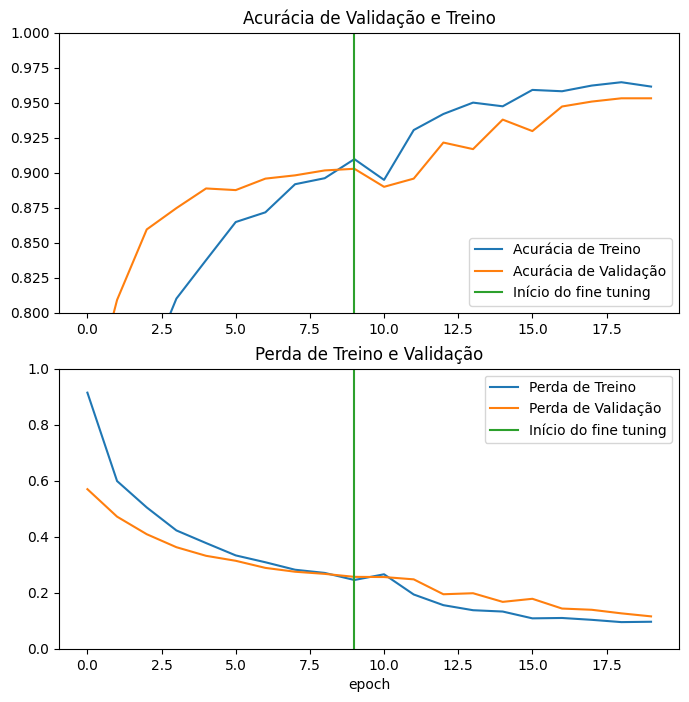

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acurácia de Treino')
plt.plot(val_acc, label='Acurácia de Validação')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Início do fine tuning')
plt.legend(loc='lower right')
plt.title('Acurácia de Validação e Treino')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda de Treino')
plt.plot(val_loss, label='Perda de Validação')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Início do fine tuning')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('epoch')
plt.show()

### Avaliação e previsão

Por fim, você pode verificar o desempenho do modelo em novos dados usando o conjunto de testes.

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9384 - loss: 0.1015
Test accuracy : 0.953125


E agora você está pronto para usar esse modelo para prever se o seu animal de estimação é um gato ou um cachorro.

Predictions:
 [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1]
Labels:
 [1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1]


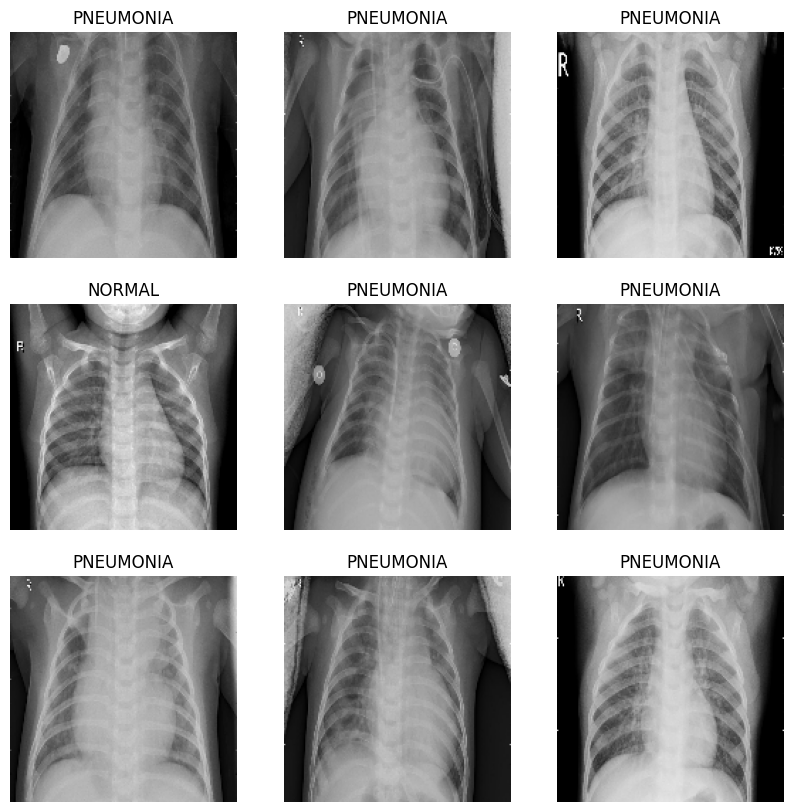

In [39]:
# Recuperar um lote de imagens do conjunto de teste
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Resumo

* **Uso de um modelo pré-treinado para extração de recursos**:  Ao trabalhar com um conjunto de dados pequeno, é uma prática comum aproveitar os recursos aprendidos por um modelo treinado em um conjunto de dados maior no mesmo domínio. Isso é feito instanciando o modelo pré-treinado e adicionando um classificador totalmente conectado por cima. O modelo pré-treinado é “congelado” e somente os pesos do classificador são atualizados durante o treinamento.
Nesse caso, a base convolucional extraiu todos os recursos associados a cada imagem e você acabou de treinar um classificador que determina a classe da imagem com base nesse conjunto de recursos extraídos.

* **Fine tuning de um modelo pré-treinado**: Para melhorar ainda mais o desempenho, é possível redirecionar as camadas de nível superior dos modelos pré-treinados para o novo conjunto de dados por meio do fine tuning.
Nesse caso, você ajustou os pesos de modo que o modelo aprendesse recursos de alto nível específicos do conjunto de dados. Essa técnica geralmente é recomendada quando o conjunto de dados de treinamento é grande e muito semelhante ao conjunto de dados original no qual o modelo pré-treinado foi treinado.

Para saber mais, visite o [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
